# CVSS Score Prediction

The CVSS is composed of three metric groups: Base, Temporal, and Environmental. But often it is only the “Base Score” that is used in databases and researches. The Base Score represents the innate characteristics of each vulnerability that is not affected by time, place or system. The figure below shows the CVSS base score formula.

<img src='cvss.jpg' width="600" height="400">

Although the CVSS is a public standard it has few restrictions. The CVSS score calculation is subjective and two users may be having different CVSS scores. On the other hands, the users should be familiar with both, the vulnerability characteristics and CVSS scoring systems.

The goal of this study is predicting the CVSS base scores based on vulnerability description using text mining. Describing the vulnerabilities to natural language is easier than to find and compute CVSS base score parameters.

In [1]:
# dependencies
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import Counter

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import seaborn as sns 

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
import multiprocessing
import time

import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

import spacy
from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score, cross_val_predict

# from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cve_cleaned.csv', header=0, index_col=0)

In [3]:
df.drop(['cwe_code' ,'mod_date', 'pub_date', 'access_authentication', 'access_complexity', 'access_vector', 'impact_availability', 'impact_confidentiality', 'impact_integrity'], axis=1, inplace=True)

In [4]:
df.head()

,cvss,cwe_name,summary
CVE-2019-2211,7.8,Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection'),"In createProjectionMapForQuery of TvProvider.java, there is possible SQL injection. This could lead to local information disclosure with no additional execution privileges needed. User interaction..."
CVE-2019-2212,4.9,Information Exposure,"In poisson_distribution of random, there is an out of bounds read. This could lead to local information disclosure with no additional execution privileges needed. User interaction is not needed fo..."
CVE-2019-2213,6.9,Use After Free,"In binder_free_transaction of binder.c, there is a possible use-after-free due to a race condition. This could lead to local escalation of privilege with no additional execution privileges needed...."
CVE-2019-2214,7.2,Improper Privilege Management,"In binder_transaction of binder.c, there is a possible out of bounds write due to a missing bounds check. This could lead to local escalation of privilege with no additional execution privileges n..."
CVE-2019-18793,4.3,Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting'),"Parallels Plesk Panel 9.5 allows XSS in target/locales/tr-TR/help/index.htm? via the ""fileName"" parameter."


***
**Tokenize words and Clean-up text**
***


In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [6]:
# remove stopwords
df['summary'] = df['summary'].apply(lambda x: ' '.join([word for word in x.split() if (word not in stop_words)]))
df.head()

,cvss,cwe_name,summary
CVE-2019-2211,7.8,Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection'),"In createProjectionMapForQuery TvProvider.java, possible SQL injection. This could lead local information disclosure additional execution privileges needed. User interaction needed exploitation.Pr..."
CVE-2019-2212,4.9,Information Exposure,"In poisson_distribution random, bounds read. This could lead local information disclosure additional execution privileges needed. User interaction needed exploitation.Product: AndroidVersions: And..."
CVE-2019-2213,6.9,Use After Free,"In binder_free_transaction binder.c, possible use-after-free due race condition. This could lead local escalation privilege additional execution privileges needed. User interaction needed exploita..."
CVE-2019-2214,7.2,Improper Privilege Management,"In binder_transaction binder.c, possible bounds write due missing bounds check. This could lead local escalation privilege additional execution privileges needed. User interaction needed exploitat..."
CVE-2019-18793,4.3,Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting'),"Parallels Plesk Panel 9.5 allows XSS target/locales/tr-TR/help/index.htm? via ""fileName"" parameter."


In [7]:
# remove digits
df['summary'] = df['summary'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
df.head()

,cvss,cwe_name,summary
CVE-2019-2211,7.8,Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection'),"In createProjectionMapForQuery TvProvider.java, possible SQL injection. This could lead local information disclosure additional execution privileges needed. User interaction needed exploitation.Pr..."
CVE-2019-2212,4.9,Information Exposure,"In poisson_distribution random, bounds read. This could lead local information disclosure additional execution privileges needed. User interaction needed exploitation.Product: AndroidVersions: And..."
CVE-2019-2213,6.9,Use After Free,"In binder_free_transaction binder.c, possible use-after-free due race condition. This could lead local escalation privilege additional execution privileges needed. User interaction needed exploita..."
CVE-2019-2214,7.2,Improper Privilege Management,"In binder_transaction binder.c, possible bounds write due missing bounds check. This could lead local escalation privilege additional execution privileges needed. User interaction needed exploitat..."
CVE-2019-18793,4.3,Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting'),"Parallels Plesk Panel . allows XSS target/locales/tr-TR/help/index.htm? via ""fileName"" parameter."


In [8]:
translator = re.compile('[%s]' % re.escape(string.punctuation))

In [9]:
# remove punctuation
df['summary'] = df['summary'].apply(lambda x: translator.sub(' ', x))
df.head()

,cvss,cwe_name,summary
CVE-2019-2211,7.8,Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection'),In createProjectionMapForQuery TvProvider java possible SQL injection This could lead local information disclosure additional execution privileges needed User interaction needed exploitation Pr...
CVE-2019-2212,4.9,Information Exposure,In poisson distribution random bounds read This could lead local information disclosure additional execution privileges needed User interaction needed exploitation Product AndroidVersions And...
CVE-2019-2213,6.9,Use After Free,In binder free transaction binder c possible use after free due race condition This could lead local escalation privilege additional execution privileges needed User interaction needed exploita...
CVE-2019-2214,7.2,Improper Privilege Management,In binder transaction binder c possible bounds write due missing bounds check This could lead local escalation privilege additional execution privileges needed User interaction needed exploitat...
CVE-2019-18793,4.3,Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting'),Parallels Plesk Panel allows XSS target locales tr TR help index htm via fileName parameter


In [10]:
# remove single letters
df['summary'] = df['summary'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
df.head()

,cvss,cwe_name,summary
CVE-2019-2211,7.8,Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection'),In createProjectionMapForQuery TvProvider java possible SQL injection This could lead local information disclosure additional execution privileges needed User interaction needed exploitation Produ...
CVE-2019-2212,4.9,Information Exposure,In poisson distribution random bounds read This could lead local information disclosure additional execution privileges needed User interaction needed exploitation Product AndroidVersions Android ...
CVE-2019-2213,6.9,Use After Free,In binder free transaction binder possible use after free due race condition This could lead local escalation privilege additional execution privileges needed User interaction needed exploitation ...
CVE-2019-2214,7.2,Improper Privilege Management,In binder transaction binder possible bounds write due missing bounds check This could lead local escalation privilege additional execution privileges needed User interaction needed exploitation P...
CVE-2019-18793,4.3,Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting'),Parallels Plesk Panel allows XSS target locales tr TR help index htm via fileName parameter


In [11]:
# one last check to see if the data cleaning hasn't completely removed all the words in some of the rows with very few words
df = df.dropna(how='any',axis=0) 

In [12]:
# to lower case
df["summary"] = df["summary"].str.lower()
df.head()

,cvss,cwe_name,summary
CVE-2019-2211,7.8,Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection'),in createprojectionmapforquery tvprovider java possible sql injection this could lead local information disclosure additional execution privileges needed user interaction needed exploitation produ...
CVE-2019-2212,4.9,Information Exposure,in poisson distribution random bounds read this could lead local information disclosure additional execution privileges needed user interaction needed exploitation product androidversions android ...
CVE-2019-2213,6.9,Use After Free,in binder free transaction binder possible use after free due race condition this could lead local escalation privilege additional execution privileges needed user interaction needed exploitation ...
CVE-2019-2214,7.2,Improper Privilege Management,in binder transaction binder possible bounds write due missing bounds check this could lead local escalation privilege additional execution privileges needed user interaction needed exploitation p...
CVE-2019-18793,4.3,Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting'),parallels plesk panel allows xss target locales tr tr help index htm via filename parameter


***
**Prepare Labels**
***

To use the most of classifiers, for example SVM and Random Forest, the number of classes should be limited. So the continuous CVSS scores could not be used for these classifiers.
To determine the label of samples, CVSS interval (that is [0 10]) was discretized to ten equal subintervals, and each of them is a class. For example, the CVSS score between zero and 0.9 is a member of the Zero-Class, the score between 1 and 1.9 is a member of the One-Class, and so on the score between 9 and 10 is a member of Nine-Class.

In [13]:
# truncate the scores column
df['cvss'] = df['cvss'].apply(np.floor)

In [14]:
df

,cvss,cwe_name,summary
CVE-2019-2211,7.0,Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection'),in createprojectionmapforquery tvprovider java possible sql injection this could lead local information disclosure additional execution privileges needed user interaction needed exploitation produ...
CVE-2019-2212,4.0,Information Exposure,in poisson distribution random bounds read this could lead local information disclosure additional execution privileges needed user interaction needed exploitation product androidversions android ...
CVE-2019-2213,6.0,Use After Free,in binder free transaction binder possible use after free due race condition this could lead local escalation privilege additional execution privileges needed user interaction needed exploitation ...
CVE-2019-2214,7.0,Improper Privilege Management,in binder transaction binder possible bounds write due missing bounds check this could lead local escalation privilege additional execution privileges needed user interaction needed exploitation p...
CVE-2019-18793,4.0,Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting'),parallels plesk panel allows xss target locales tr tr help index htm via filename parameter
...,...,...,...
CVE-2004-2182,7.0,Improper Authentication,session fixation vulnerability macromedia jrun allows remote attackers hijack user sessions pre setting user session id information used session server
CVE-2003-1562,7.0,Concurrent Execution using Shared Resource with Improper Synchronization ('Race Condition'),sshd openssh earlier permitrootlogin disabled using pam keyboard interactive authentication insert delay root login attempt correct password makes easier remote attackers use timing differences de...
CVE-2002-2230,4.0,Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting'),cross site scripting xss vulnerability ikonboard allows remote attackers inject arbitrary web script html via private message javascript url img tag url ends gif jpg string variant cve
CVE-2002-1991,7.0,Improper Control of Generation of Code ('Code Injection'),php file inclusion vulnerability oscommerce execute arbitrary commands via include file parameter include once php


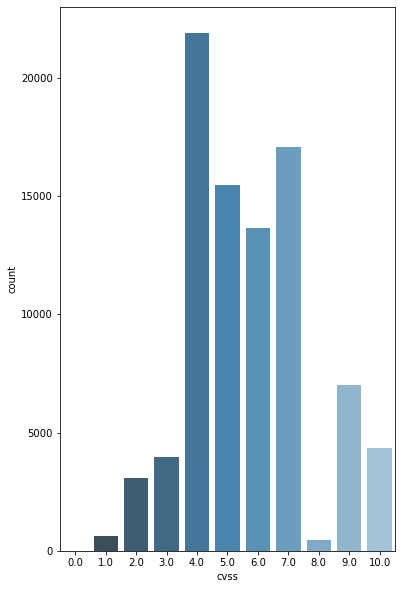

In [16]:
f, ax = plt.subplots(figsize=(6, 10))
sns.countplot(x="cvss", data=df, palette='Blues_d')

In [17]:
df['cvss'].value_counts()

4.0     21898
7.0     17099
5.0     15457
6.0     13662
9.0      7008
10.0     4354
3.0      3966
2.0      3069
1.0       631
8.0       468
0.0         1
Name: cvss, dtype: int64

Remarks:

- Most of the vulnerabilities are scored as 4, 5, 6 or 7.

- The other classes are not very well represented, and might need upsampling. Another option to deal with the imbalance is to choose an appropriate metric, like F1 score or AUC.

- Class 0 only has 1 value, it is difficult to make predictions based on that. Apart from that, it is also probably mistake and very unlikely, according to the calculation of the score as given above.

In [18]:
# remove class 0 as it only contains 1 element.
# this would not let us stratify on cvss later on and have an equal distribution of class in the train-test-split
df = df[(df["cvss"]>0)]

***
**Performance Metric**
***

We are predicting the CVSS scores from 1 to 10. The score is an ordinal variable meaning that ordering is important. This can be viewed as a classification or an ordinal regression problem. (Ordinal regression is sometimes described as an problem somewhere in between classification and regression.)

To measure the performance of our algorithms, we'll use the F1 score which balances the precision and recall of a classifier. Traditionally, the F1 score is used to evaluate performance on a binary classifier, but since we have three possible labels we will use a variant called the micro averaged F1 score.

$$F_{micro} = \frac{2 \cdot P_{micro} \cdot R_{micro}}{P_{micro} + R_{micro}}$$

where

$$P_{micro} = \frac{\sum_{k=1}^{3}TP_{k}}{\sum_{k=1}^{3}(TP_{k} + FP_{k})},~~R_{micro} = \frac{\sum_{k=1}^{3}TP_{k}}{\sum_{k=1}^{3}(TP_{k} + FN_{k})}$$

and TP is True Positive, FP is False Positive, FN is False Negative, and k represents each class in 1,2,...,10.

***
**Feature Engineering**
***

In [19]:
cumulative_sum = {}

for x in df["summary"].values:
    cumulative_sum.update(dict.fromkeys(set(x.lower().split())))

In [20]:
print(len(cumulative_sum))

67312


In [21]:
# keep the same random state for reproducibility
RANDOM_STATE = 12
TRAIN_TEST_SPLIT_SIZE = .1

In [22]:
texts = df['summary'].astype('str')
labels = df['cvss']

In [23]:
wpt = nltk.WordPunctTokenizer()
tokenized_texts = [wpt.tokenize(text) for text in texts]

In [24]:
x_train, x_test, y_train, y_test = train_test_split(tokenized_texts, labels,
                                                  test_size = TRAIN_TEST_SPLIT_SIZE, stratify = labels,
                                                  random_state = RANDOM_STATE)

In [25]:
np.save("train_dataset_features.npy", np.array(x_train))
np.save("train_dataset_labels.npy", np.array(y_train))

In [26]:
np.save("test_dataset_features.npy", np.array(x_test))
np.save("test_dataset_labels.npy", np.array(y_test))

In [27]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = lambda x: x,
                        preprocessor = lambda x: x, 
                        min_df = 5, max_df = 0.8) 
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train) 
x_test_tfidf = tfidf_vectorizer.transform(x_test)

x_train_tfidf.shape

(78850, 12196)

In [28]:
# return a list of (term, score/frequency) pairs for each distinct term 
scores = np.asarray(x_train_tfidf.mean(axis = 0)).ravel().tolist()
scores_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names(), 'tfidf': scores})
df_tfidf = scores_df.sort_values(by = 'tfidf', ascending = False).head(50)

In [29]:
df_tfidf

,word,tfidf
11349,via,0.036886
355,allows,0.036310
8764,remote,0.036114
713,attackers,0.034418
11523,vulnerability,0.033738
544,arbitrary,0.030981
7752,php,0.028014
2328,cve,0.023746
10546,the,0.022931
3477,execute,0.022794


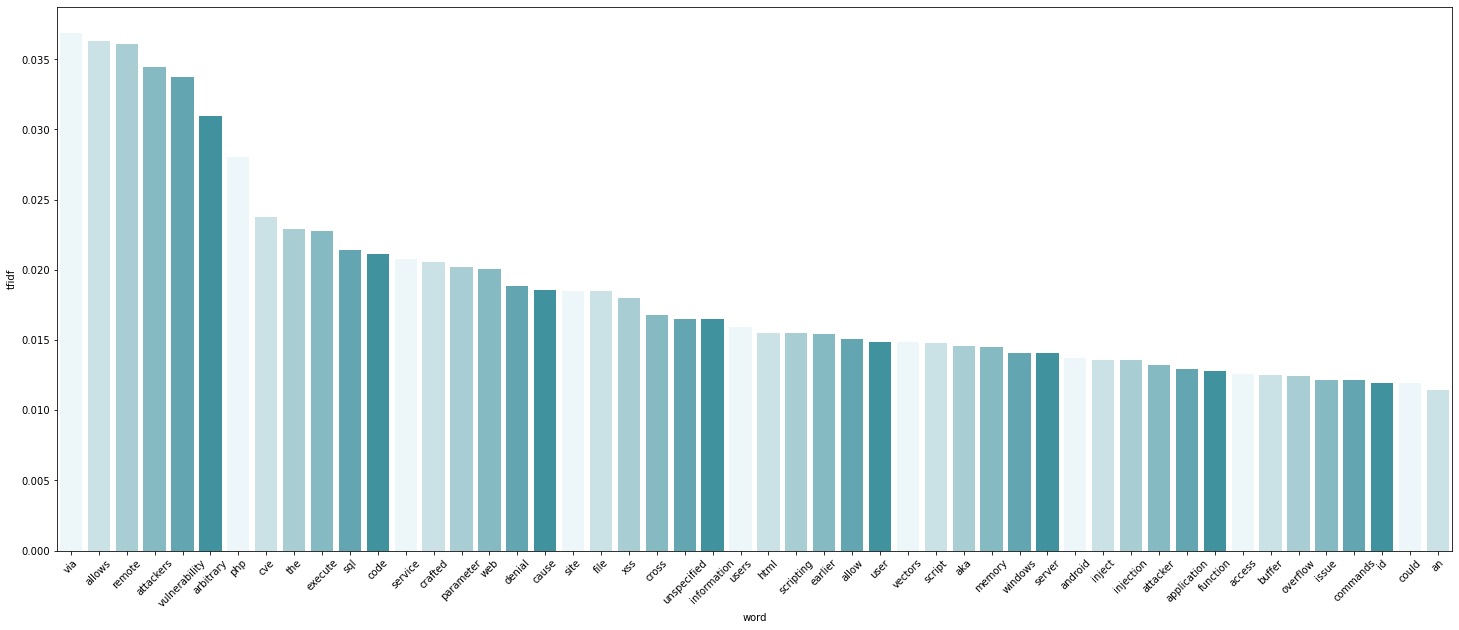

In [30]:
plt.figure(figsize = (25,10))
sns.barplot(x = 'word', y = 'tfidf', data = df_tfidf, palette = sns.light_palette((210, 90, 60), input = "husl"))
plt.xticks(rotation = 45)
plt.show()

***
**Prepare Features**
***

In [31]:
np.save("train_dataset_tfidf_features.npy", np.array(x_train_tfidf))
np.save("train_dataset_tfidf_labels.npy", np.array(y_train))

In [32]:
np.save("test_dataset_tfidf_features.npy", np.array(x_test_tfidf))
np.save("test_dataset_tfidf_labels.npy", np.array(y_test))

***
**Visualize TF-IDF Features**
***

In [33]:
print(repr(x_train_tfidf))

<78850x12196 sparse matrix of type '<class 'numpy.float64'>'
	with 1850564 stored elements in Compressed Sparse Row format>


The TF-IDF features form a sparse matrix, which we can try to visualize using a heatmap and select only 100 dimension to preserve a certain visibility.

Text(0.5, 1.0, 'Sparse Matrix 100 Sample')

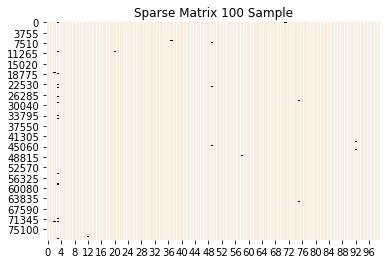

In [34]:
sns.heatmap(x_train_tfidf.todense()
            [:,np.random.randint(0, x_train_tfidf.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix 100 Sample')

***
**Baseline: most frequent class**
***

In [35]:
strategies = ['most_frequent', 'stratified', 'uniform']
  
test_scores = []
for s in strategies:
    dclf = DummyClassifier(strategy = s, random_state = 0)
    dclf.fit(x_train_tfidf, y_train)
#     score = dclf.score(x_val_tfidf, y_val)
    y_pred = dclf.predict(x_test_tfidf)
    score = f1_score(y_test, y_pred, average='micro')

    test_scores.append(score)

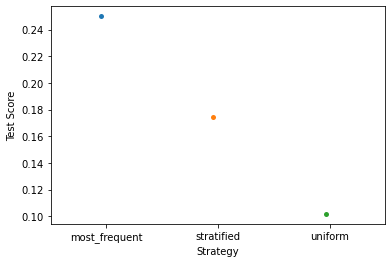

In [36]:
ax = sns.stripplot(strategies, test_scores);
ax.set(xlabel ='Strategy', ylabel ='Test Score')
plt.show()

Out of the "dummy classifiers" tested, the most-frequent strategy showed the highest F1 score. This will be the baseline against which we compare the next models.

***
**Model Selection**
***

In [37]:
def check_model_and_test(x_train, y_train, x_test, y_test, classifiers):
    for model in classifiers:
        this_model = model.__class__.__name__ #get the name of the classifier
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        print(f'{this_model} f1 score:')
        score = f1_score(y_test, y_pred, average='micro')
        print(f'{score:.4f}')
        print('\n')

In [38]:
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()]

In [39]:
check_model_and_test(x_train_tfidf, y_train, x_test_tfidf, y_test, classifiers)

KNeighborsClassifier f1 score:
0.5517


DecisionTreeClassifier f1 score:
0.6125


RandomForestClassifier f1 score:
0.6778


AdaBoostClassifier f1 score:
0.4840


GradientBoostingClassifier f1 score:
0.6289




***
**Random Forest**
***
Random Forest is an ensemble bagging model. It creates a set of decision trees from randomly selected subset of training set and then aggregates the votes from different decision trees to decide the final class of the test object. In that way, random forest will get lower variance compared to decision tree because the decision tree is more sensitive to specific data and only one single decision tree is built. Moreover, random forest will get less overfit issues even when the number of trees is increased.

Randome Forest has the best F1 score, so I'll continue with optimizing Random Forest further.

***
**Model Optimization**
***

Most generally, a hyperparameter is a parameter of the model that is set prior to the start of the learning process. Different models have different hyperparameters that can be set. For a Random Forest Classifier, there are several different hyperparameters that can be adjusted. For now I will concentrate on the following four parameters:
1. **n_estimators**: The n_estimators parameter specifies the number of trees in the forest of the model. The default value for this parameter is 10, which means that 10 different decision trees will be constructed in the random forest.
2. **max_depth**: The max_depth parameter specifies the maximum depth of each tree. The default value for max_depth is None, which means that each tree will expand until every leaf is pure. A pure leaf is one where all of the data on the leaf comes from the same class.
3. **min_samples_split**: The min_samples_split parameter specifies the minimum number of samples required to split an internal leaf node. The default value for this parameter is 2, which means that an internal node must have at least two samples before it can be split to have a more specific classification.
4. **min_samples_leaf**: The min_samples_leaf parameter specifies the minimum number of samples required to be at a leaf node. The default value for this parameter is 1, which means that every leaf must have at least 1 sample that it classifies.

In [40]:
# Create the random grid
random_grid = {
               # Number of trees in random forest
               'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
               # Number of features to consider at every split
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 10 * 2 * 11 * 3 * 3 * 2 settings! However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

A common extension of randomized/grid search is to use it alongside cross validation, training on several different folds for each hyperparameter combination to have a more reliable estimate of each model’s performance out of sample.

K-fold cross validation works by breaking the training data into K equal-sized “folds.” It iterates through each fold, treating that fold as holdout data, training a model on all the other K-1 folds, and evaluating the model’s performance on the one holdout fold. This results in having K different models, each with an out of sample model accuracy score on a different holdout set. The average of these K models’ out-of-sample scores is the model’s cross-validation score.

Cross validation is useful because it provides a lower-variance estimate of the model’s true out of sample score than if you had only used a single train-test split.

Here I will use a stratified K-fold cross validation to preserve the distribution of classes, due to the imbalance in the dataset and set the number of fold to 2, since I already have a test set. In reality it is advisable to keep a completely separate, unseen test set because during the grid search process some information about the dataset, over which we perform a grid search leaks into the hyperparameters. To get a final, unbiased performance on the new data we need to hold out a sample of a dataset which was never seen by fit classifier - ever, directly or indirectly.

In [41]:
kf_2_cv = StratifiedKFold(n_splits = 2, random_state = RANDOM_STATE, shuffle = True)

In [42]:
kf_5_cv = StratifiedKFold(n_splits = 5, random_state = RANDOM_STATE, shuffle = True)

In [43]:
rf_clf = RandomForestClassifier()

The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 2 respectively). More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [44]:
rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, n_iter = 100, cv = kf_2_cv, scoring = 'f1_micro', verbose = 5, random_state = RANDOM_STATE, n_jobs = 1)

In [45]:
# Fit the random search model
rf_random.fit(x_train_tfidf, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV 1/2] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV 2/2] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV 1/2] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV 2/2] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV 1/2] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.0min
[CV 2/2] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.0min
[CV 1/2] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samp

[CV 1/2] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 9.6min
[CV 2/2] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=10.1min
[CV 1/2] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.1min
[CV 2/2] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.3min
[CV 1/2] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 1.9min
[CV 2/2] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 1.9min
[CV 1/2] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 2.5min
[CV 2/2] END 

[CV 2/2] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  13.6s
[CV 1/2] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 1.5min
[CV 2/2] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 1.6min
[CV 1/2] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 3.1min
[CV 2/2] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 2.7min
[CV 1/2] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  36.8s
[CV 2/2] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  35.5s
[CV 1/2] E

[CV 1/2] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time= 1.7min
[CV 2/2] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time= 1.6min
[CV 1/2] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 4.9min
[CV 2/2] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 5.1min
[CV 1/2] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  16.8s
[CV 2/2] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  16.5s
[CV 1/2] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  59.0s
[CV 2/2] END boots

RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=12, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=12, scoring='f1_micro', verbose=5)

In [46]:
rf_random.best_score_

0.6681927710843374

In [47]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': False}

From these results, we should be able to narrow the range of values for each hyperparameter.

In [48]:
best_random = rf_random.best_estimator_

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify different combinations of settings to try concentrated around the best parameters from the randomized search.

This can be done with GridSearchCV, a method which instead of sampling randomly from a distribution, evaluates all combinations that we define. We feed it a set of hyperparameters and the values we want to test for each hyperparameter, and then run an exhaustive search over all possible combinations of these values, training one model for each set of values. The algorithm then compares the scores of each model it trains and keeps the best one. To use Grid Search, we make another parameter grid based on the best values provided by random search.

In [53]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [110, 120],
    'max_features': ['auto'],
    'min_samples_split': [10],
    'min_samples_leaf': [1],
    'n_estimators': [850, 900, 950]
}
print(param_grid)

{'bootstrap': [False], 'max_depth': [110, 120], 'max_features': ['auto'], 'min_samples_split': [10], 'min_samples_leaf': [1], 'n_estimators': [850, 900, 950]}


In [54]:
rf_cv = GridSearchCV(estimator = rf_clf, param_grid = param_grid, cv = kf_5_cv, scoring = 'f1_micro', verbose = 5, n_jobs = 1)

In [55]:
rf_cv.fit(x_train_tfidf, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=850; total time=20.7min
[CV 2/5] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=850; total time=18.3min
[CV 3/5] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=850; total time=18.2min
[CV 4/5] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=850; total time=21.8min
[CV 5/5] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=850; total time=20.7min
[CV 1/5] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=22.7min
[CV 2/5] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'bootstrap': [False], 'max_depth': [110, 120],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [10],
                         'n_estimators': [850, 900, 950]},
             scoring='f1_micro', verbose=5)

In [56]:
rf_cv.best_score_ 

0.6827647431832593

In [57]:
rf_cv.best_params_ 

{'bootstrap': False,
 'max_depth': 120,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 950}

In [58]:
rf = rf_cv.best_estimator_

In [59]:
rf.fit(x_train_tfidf, y_train)
y_pred_rf = rf.predict(x_test_tfidf)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text major ticklabel objects>)

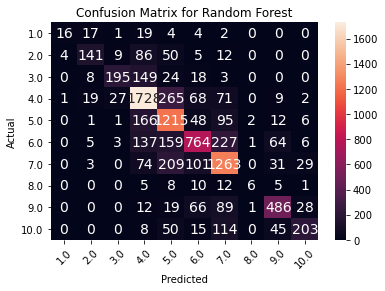

In [60]:
df_cm_rf = pd.DataFrame(confusion_matrix(y_test, y_pred_rf), columns=np.unique(y_test), index = np.unique(y_test))
df_cm_rf.index.name = 'Actual'
df_cm_rf.columns.name = 'Predicted'

sns.heatmap(df_cm_rf, annot=True, fmt='d', annot_kws={"size": 14})
plt.title("Confusion Matrix for Random Forest")
plt.xticks(rotation=45)
plt.yticks(rotation=360)

We are doing decently on classifying the majority classes accurately, but we are misclassiflying a big fraction of the other labels. As was to be expected class imbalance seems to be causing some problem. We can try using class weights to address class imbalance, or upsampling with SMOTE.

Let's look at the classification report.

In [61]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         1.0       0.76      0.25      0.38        63
         2.0       0.73      0.46      0.56       307
         3.0       0.83      0.49      0.62       397
         4.0       0.72      0.79      0.76      2190
         5.0       0.61      0.79      0.68      1546
         6.0       0.70      0.56      0.62      1366
         7.0       0.67      0.74      0.70      1710
         8.0       0.60      0.13      0.21        47
         9.0       0.75      0.69      0.72       701
        10.0       0.74      0.47      0.57       435

    accuracy                           0.69      8762
   macro avg       0.71      0.54      0.58      8762
weighted avg       0.70      0.69      0.68      8762



These classification reports show that the precision for all classes seems really good, while the recall has good values only for the majority classes, which can be expected, looking at the labels distribution.

Tens of thousands of vulnerabilities were discovered until now. But almost all organizations have the limited resources to address all vulnerabilities that might affect their systems. The CVSS is the standard prioritization system for vulnerabilities. The calculation of CVSS score is somewhat subjective and the users should be familiar with both, the vulnerability characteristics and the CVSS scoring systems.
The goal of this mini-project was predicting the CVSS base scores, based on vulnerability descriptions and text mining techniques. The results show that there is some untapped potential of text mining for CVSS score prediction.

In [ ]:
import shap
explainer = shap.TreeExplainer(rf)
shap.initjs()
shap_values = explainer.shap_values(y_pred_rf, approximate=True)

In [ ]:
from lime import lime_text

explainer = lime_text.LimeTextExplainer(class_names=df.cvss)
explainer

In [ ]:
text_test = 'An information disclosure vulnerability exists when the Windows kernel improperly handles objects in memory. An attacker who successfully exploited this vulnerability could obtain information to further compromise the user’s system'

In [ ]:
def pred_fn(text):
    text_transformed = tfidf_vectorizer.transform(text)
    return rf.predict_proba(text_transformed)

pred_fn(text_test[:2])

In [ ]:
idx = random.randint(1, len(text_test))

print("Actual Text : ", text_test[idx])

print("Prediction : ", rf.predict(x_test_tfidf[idx].reshape(1,-1))[0])
print("Actual :     ", y_test[idx])

explanation = explainer.explain_instance(text_test[idx], classifier_fn=pred_fn)

explanation.show_in_notebook()

***
**Ideas for future work**
***

It would be interesting to consider multiple cases for the Random-Forest experiments:
- Feature dimension reduction, either using LDA or PCA or a combination of both as opposed to using the all features (without data dimension reduction) like I did in this notebook
- Class weights or SMOTE to handle the imbalanced classes.
- Different classifiers, like SVM.